Imports

In [ ]:
import requests
import json
import time
import random
import csv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

import numpy as np

!pip install vaderSentiment

API calls for professor info + reviews

In [ ]:
profs = {}
offset = 0
batch_size = 100

while True:
    response = requests.get(
        f"https://planetterp.com/api/v1/professors?reviews=true&type=professor&limit={batch_size}&offset={offset}"
    )
    profs_data = response.json()


    if not profs_data:
        break

    for prof_data in profs_data:
        if prof_data["average_rating"] == None:
            continue

        name = prof_data["name"]
        to_add = {
            "slug": prof_data["slug"],
            "type": prof_data["type"],
            "courses": prof_data["courses"],
            'average_rating': prof_data["average_rating"],
            "reviews": prof_data["reviews"]
        }
        profs[name] = to_add

    offset += batch_size

# Save the full file after scraping
with open("professors.json", "w", encoding="utf-8") as f:
    json.dump(profs, f, indent=2)

API calls for grades - calculate average GPA for each professor base on past grades

In [ ]:
def calculate_average_gpa(grade_data):
    gpa_values = {
        'A+': 4.0, 'A': 4.0, 'A-': 3.7,
        'B+': 3.3, 'B': 3.0, 'B-': 2.7,
        'C+': 2.3, 'C': 2.0, 'C-': 1.7,
        'D+': 1.3, 'D': 1.0, 'D-': 0.7,
        'F': 0.0
    }

    total_points = 0.0
    total_students = 0

    for section in grade_data:
        for grade, value in gpa_values.items():
            count = section.get(grade, 0)
            total_points += count * value
            total_students += count

    if total_students == 0:
        return None  # Avoid division by zero

    average_gpa = total_points / total_students
    return round(average_gpa, 3)

with open('professors.json', 'r') as f:
    professor_data = json.load(f)

results = []

for name in professor_data.keys():
    try:
        url = f"https://planetterp.com/api/v1/grades?professor={name}"
        response = requests.get(url)
        response.raise_for_status()
        grades_data = response.json()

        avg_gpa = calculate_average_gpa(grades_data)
        results.append({
            "name": name,
            "average_gpa": avg_gpa
        })


    except Exception as e:
        print(f"Failed for {name}: {e}")
        results.append({
            "name": name,
            "average_gpa": None
        })

print(f"Number of average gpa calculated: {len(results)}")


# Save results
with open('professors_with_avg_gpa.json', 'w') as f:
    json.dump(results, f, indent=2)

Number of average gpa calculated: 4211


Compute Average GPA and Expected GPA

In [ ]:
gpa_values = {
    'A+': 4.0, 'A': 4.0, 'A-': 3.7,
    'B+': 3.3, 'B': 3.0, 'B-': 2.7,
    'C+': 2.3, 'C': 2.0, 'C-': 1.7,
    'D+': 1.3, 'D': 1.0, 'D-': 0.7,
    'F': 0.0
}

# Compute average expected GPA from reviews
def calculate_average_expected_gpa(reviews):
    total = 0.0
    count = 0
    for review in reviews:
        expected = review.get("expected_grade", "")
        if expected in gpa_values:
            total += gpa_values[expected]
            count += 1
    if count == 0:
        return None
    return round(total / count, 3)

# Load professor data
with open('professors.json', 'r') as f:
    professors = json.load(f)

# Load precomputed average GPA data
with open('professors_with_avg_gpa.json', 'r') as f:
    avg_gpa_data = json.load(f)

# Convert list to dictionary for quick lookup
avg_gpa_lookup = {prof["name"]: prof["average_gpa"] for prof in avg_gpa_data}

results = []

# Merge data
for name, data in professors.items():
    avg_gpa = avg_gpa_lookup.get(name)  # Look up from precomputed file
    reviews = data.get("reviews", [])
    avg_expected = calculate_average_expected_gpa(reviews)

    results.append({
        "name": name,
        "average_gpa": avg_gpa,
        "average_expected_gpa": avg_expected
    })

# Save result
with open('professor_gpa_features.json', 'w') as f:
    json.dump(results, f, indent=2)

Generate Sentiment Analysis from reviews

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

with open("professors.json", "r", encoding="utf-8") as f:
  professors = json.load(f)

analyzer = SentimentIntensityAnalyzer()

sentiment_scores = {}

for name, data in professors.items():
    reviews = data["reviews"]
    total_score = 0
    count = 0

    for review in reviews:
        text = review["review"]
        sentiment = analyzer.polarity_scores(text)
        total_score += sentiment["compound"]
        count += 1

    if count > 0:
        avg_score = total_score / count
        sentiment_scores[name] = avg_score

with open("professor_sentiment.json", "w", encoding="utf-8") as f:
    json.dump(sentiment_scores, f, indent=2)

API call for average rating of each professor - use to train model

In [ ]:
profs = {}
offset = 0
batch_size = 100

while True:
    response = requests.get(
        f"https://planetterp.com/api/v1/professors?rtype=professor&limit={batch_size}&offset={offset}"
    )
    profs_data = response.json()


    if not profs_data:
        break

    for prof_data in profs_data:
        if prof_data["average_rating"] == None:
            continue

        name = prof_data["name"]
        to_add = {
            'average_rating': prof_data["average_rating"],
        }
        profs[name] = to_add

    offset += batch_size

# Save the full file after scraping
with open("professors_average_rating.json", "w", encoding="utf-8") as f:
    json.dump(profs, f, indent=2)

Combine files into one csv for training

In [ ]:
# Load list of professors with average GPA and expected GPA
with open('professor_gpa_features.json', 'r') as f:
    gpa_data = json.load(f)

# Load sentiment dictionary (name -> sentiment score)
with open('professor_sentiment.json', 'r') as f:
    sentiment_data = json.load(f)

# Load professor average ratings (name -> average_rating)
with open('professors_average_rating.json', 'r') as f:
    rating_data = json.load(f)

combined = []

# Go through each professor in GPA list
for prof in gpa_data:
    name = prof["name"]
    avg_gpa = prof.get("average_gpa")
    avg_expected = prof.get("average_expected_gpa")
    sentiment = sentiment_data.get(name)
    star_rating = rating_data.get(name, {}).get("average_rating")  # Get star_rating, if available

    # Only include if sentiment exists and star_rating is available
    if sentiment is not None and star_rating is not None:
        combined.append({
            "name": name,
            "average_gpa": avg_gpa,
            "average_expected_gpa": avg_expected,
            "sentiment": sentiment,
            "star_rating": star_rating
        })


# Write to CSV
with open('professor_features.csv', 'w', newline='') as f:
    fieldnames = ["name", "average_gpa", "average_expected_gpa", "sentiment", "star_rating"]
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(combined)

Split data into training set and testing set

In [ ]:
# Load the CSV file into a pandas DataFrame
df = pd.read_csv('professor_features.csv')

# drop missing values
df = df.dropna()

# Features (X) and Target (y)
X = df[["average_gpa", "average_expected_gpa", "sentiment"]]  # Features
y = df["star_rating"]  # Target (Star rating)

# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the size of the split
print("Training data size:", len(X_train))
print("Testing data size:", len(X_test))

Training data size: 2926
Testing data size: 732


Model Training

In [ ]:
# Train Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Train the Random Forest Regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Create the KNN regressor model
knn_model = KNeighborsRegressor(n_neighbors=23)

# Train the Support Vector Machine model
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train, y_train)

print("Training Complete!")

Training Complete!


Linear Regression Model Evaulation

In [ ]:
# Function to perform 10-fold cross-validation for Linear Regression
def evaluate_lr_model(X, y):
    scores = cross_val_score(lr_model, X, y, cv=10, scoring='neg_mean_squared_error')
    mse_scores = -scores  # Convert from negative MSE to positive MSE
    r2_scores = cross_val_score(lr_model, X, y, cv=10, scoring='r2')

    print(f"\nEvaluating Linear Regression with 10-fold Cross-validation:")
    print(f"Mean Squared Error (MSE) (10-fold CV): {np.mean(mse_scores):.4f}")
    print(f"R2 Score (10-fold CV): {np.mean(r2_scores):.4f}")

# Evaluate Linear Regression model using 10-fold cross-validation
evaluate_lr_model(X_test, y_test)


Evaluating Linear Regression with 10-fold Cross-validation:
Mean Squared Error (MSE) (10-fold CV): 0.5104
R2 Score (10-fold CV): 0.6100


Random Forest Model Evaulation with

In [ ]:
# Function to perform 10-fold cross-validation for Random Forest
def evaluate_rf_model(X, y):
    scores = cross_val_score(rf_model, X, y, cv=10, scoring='neg_mean_squared_error')
    mse_scores = -scores  # Convert from negative MSE to positive MSE
    r2_scores = cross_val_score(rf_model, X, y, cv=10, scoring='r2')

    print(f"\nEvaluating Random Forest with 10-fold Cross-validation:")
    print(f"Mean Squared Error (MSE) (10-fold CV): {np.mean(mse_scores):.4f}")
    print(f"R2 Score (10-fold CV): {np.mean(r2_scores):.4f}")

# Evaluate Random Forest model using 10-fold cross-validation
evaluate_rf_model(X_test, y_test)


Evaluating Random Forest with 10-fold Cross-validation:
Mean Squared Error (MSE) (10-fold CV): 0.5397
R2 Score (10-fold CV): 0.5868


KNN Model Evaulation

In [ ]:
knn_cv_scores = cross_val_score(knn_model, X, y, cv=10, scoring='neg_mean_squared_error')
knn_mean_mse = -knn_cv_scores.mean()  # Convert back from negative MSE
knn_std_mse = knn_cv_scores.std()

print(f"KNN Mean MSE: {knn_mean_mse}")
print(f"KNN MSE Standard Deviation: {knn_std_mse}")

KNN Mean MSE: 0.44458481401786826
KNN MSE Standard Deviation: 0.07019833510240824


Support Vector Machines Model Evaulation

In [ ]:
# Function to perform 10-fold cross-validation for SVM
def evaluate_svm_model(X, y):
    scores = cross_val_score(svm_model, X, y, cv=10, scoring='neg_mean_squared_error')
    mse_scores = -scores  # Convert from negative MSE to positive MSE
    r2_scores = cross_val_score(svm_model, X, y, cv=10, scoring='r2')

    print(f"\nEvaluating SVM with 10-fold Cross-validation:")
    print(f"Mean Squared Error (MSE) (10-fold CV): {np.mean(mse_scores):.4f}")
    print(f"R2 Score (10-fold CV): {np.mean(r2_scores):.4f}")

# Evaluate SVM model using 10-fold cross-validation
evaluate_svm_model(X_test, y_test)


Evaluating SVM with 10-fold Cross-validation:
Mean Squared Error (MSE) (10-fold CV): 0.5008
R2 Score (10-fold CV): 0.6177


Important feature

In [ ]:
# Get feature importances from the Random Forest model
importances = rf_model.feature_importances_

# Match importances to feature names
feature_names = X.columns
feature_importances = dict(zip(feature_names, importances))

# Print feature importances nicely
print("Feature Importance from Random Forest Regression Model")
for feature, importance in feature_importances.items():
    print(f"{feature}: {importance:.4f}")

Feature Importance from Random Forest Regression Model
average_gpa: 0.1477
average_expected_gpa: 0.1115
sentiment: 0.7408


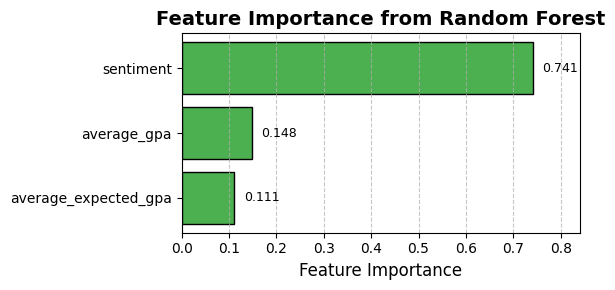

In [ ]:
sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
names = [item[0] for item in sorted_features]
values = [item[1] for item in sorted_features]

# Plot
plt.figure(figsize=(6, 3))
bars = plt.barh(names, values, color='#4CAF50', edgecolor='black')

# Add value labels inside the bars or slightly to the right
for bar in bars:
    plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.3f}', va='center', fontsize=9)

# Styling
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Feature Importance from Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Extend x-axis limit slightly
plt.xlim(0, max(values) + 0.1)

plt.tight_layout()
plt.show()